In [1]:
!nvidia-smi

Wed Mar  3 23:16:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 450.57       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:18:00.0 Off |                  N/A |
| 38%   61C    P2    89W / 250W |   1126MiB / 11016MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
import numpy as np
import os 
import matplotlib.pyplot as plt
os.getcwd()
os.environ['CUDA_VISIBLE_DEVICES'] = "0" 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10000)]) 
    except RuntimeError as e:
        print(e)

In [3]:
# Download and prepare the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

IMAGE_SIZE, IMAGE_DEPTH = 32, 3
EPOCH = 100
BATCH_SIZE = 128

In [4]:
inputs_img = tf.keras.Input(shape = (IMAGE_SIZE, IMAGE_SIZE, IMAGE_DEPTH))
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding = 'same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_DEPTH))(inputs_img)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding = 'same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding = 'same')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs_img, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0     

In [5]:
model.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_hist = model.fit(train_images, train_labels, epochs=EPOCH, batch_size = 128, validation_split=0.3)

Train on 35000 samples, validate on 15000 samples
Epoch 1/100
35000/35000 [==============================] - 8s 242us/sample - loss: 2.2181 - accuracy: 0.1842 - val_loss: 2.1479 - val_accuracy: 0.1967
Epoch 2/100
35000/35000 [==============================] - 3s 98us/sample - loss: 2.0063 - accuracy: 0.2696 - val_loss: 1.9203 - val_accuracy: 0.3181
Epoch 3/100
35000/35000 [==============================] - 3s 98us/sample - loss: 1.9049 - accuracy: 0.3180 - val_loss: 1.9349 - val_accuracy: 0.3226
Epoch 4/100
35000/35000 [==============================] - 3s 98us/sample - loss: 1.8161 - accuracy: 0.3514 - val_loss: 1.7699 - val_accuracy: 0.3664
Epoch 5/100
35000/35000 [==============================] - 3s 98us/sample - loss: 1.7342 - accuracy: 0.3816 - val_loss: 1.7163 - val_accuracy: 0.3955
Epoch 6/100
35000/35000 [==============================] - 3s 99us/sample - loss: 1.6633 - accuracy: 0.4066 - val_loss: 1.6027 - val_accuracy: 0.4320
Epoch 7/100
35000/35000 [========================

Epoch 55/100
35000/35000 [==============================] - 3s 99us/sample - loss: 0.6225 - accuracy: 0.7825 - val_loss: 0.9016 - val_accuracy: 0.6951
Epoch 56/100
35000/35000 [==============================] - 3s 99us/sample - loss: 0.6117 - accuracy: 0.7887 - val_loss: 0.9259 - val_accuracy: 0.6901
Epoch 57/100
35000/35000 [==============================] - 3s 100us/sample - loss: 0.5952 - accuracy: 0.7946 - val_loss: 0.9316 - val_accuracy: 0.6866
Epoch 58/100
35000/35000 [==============================] - 3s 99us/sample - loss: 0.5853 - accuracy: 0.7965 - val_loss: 0.9340 - val_accuracy: 0.6923
Epoch 59/100
35000/35000 [==============================] - 3s 100us/sample - loss: 0.5718 - accuracy: 0.8030 - val_loss: 0.8834 - val_accuracy: 0.7024
Epoch 60/100
35000/35000 [==============================] - 3s 99us/sample - loss: 0.5547 - accuracy: 0.8075 - val_loss: 0.9083 - val_accuracy: 0.6945
Epoch 61/100
35000/35000 [==============================] - 3s 99us/sample - loss: 0.5441 - 

In [6]:
class FC_dropconnect(tf.keras.layers.Layer):
    def __init__(self, units = 32, prob = 0.5):
        super(FC_dropconnect, self).__init__()
        self.units = units
        self.relu = tf.keras.layers.ReLU()
        self.prob = prob
        
    def build(self, input_shape):
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(initial_value=w_init(shape=(input_shape[-1], self.units), dtype="float32"),trainable=True)
        # w is a matrix with shape (input_dim, output_dim)
        
        b_init = tf.zeros_initializer()
        self.b = tf.Variable(initial_value=b_init(shape=(self.units,), dtype="float32"), trainable=True)
        # b is a matrix with shape (output_dim, 1)
        
        mask_matrix = tf.Variable(tf.cast(tf.math.greater(tf.random.uniform(shape=(input_shape[-1], self.units), maxval=1), self.prob), tf.float32), trainable=False)
        self.w = self.w * mask_matrix
        
    def call(self, inputs):
        return self.relu(tf.matmul(inputs, self.w) + self.b)

In [7]:
inputs_img = tf.keras.Input(shape = (IMAGE_SIZE, IMAGE_SIZE, IMAGE_DEPTH))
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding = 'same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_DEPTH))(inputs_img)
x, _, _ = tf.nn.fractional_max_pool(x, pooling_ratio = 1.2)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding = 'same')(x)
x, _, _ = tf.nn.fractional_max_pool(x, pooling_ratio = 1.2)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding = 'same')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
model_FMP = tf.keras.Model(inputs=inputs_img, outputs=outputs)
model_FMP.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
tf_op_layer_FractionalMaxPoo [(None, 26, 26, 32), (26, 0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 64)        18496     
_________________________________________________________________
tf_op_layer_FractionalMaxPoo [(None, 21, 21, 64), (21, 0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 56448)             0   

In [8]:
model_FMP.compile(optimizer='SGD',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

model_FMP_hist = model_FMP.fit(train_images, train_labels, epochs=EPOCH, batch_size = 128, validation_split=0.3)

Train on 35000 samples, validate on 15000 samples
Epoch 1/100
35000/35000 [==============================] - 37s 1ms/sample - loss: 2.1030 - accuracy: 0.2319 - val_loss: 1.9378 - val_accuracy: 0.3101
Epoch 2/100
35000/35000 [==============================] - 35s 996us/sample - loss: 1.8818 - accuracy: 0.3303 - val_loss: 1.7995 - val_accuracy: 0.3632
Epoch 3/100
35000/35000 [==============================] - 35s 990us/sample - loss: 1.7827 - accuracy: 0.3682 - val_loss: 1.7124 - val_accuracy: 0.3975
Epoch 4/100
35000/35000 [==============================] - 35s 997us/sample - loss: 1.7183 - accuracy: 0.3932 - val_loss: 1.6666 - val_accuracy: 0.4154
Epoch 5/100
35000/35000 [==============================] - 35s 989us/sample - loss: 1.6480 - accuracy: 0.4139 - val_loss: 1.5985 - val_accuracy: 0.4314
Epoch 6/100
35000/35000 [==============================] - 35s 994us/sample - loss: 1.6017 - accuracy: 0.4290 - val_loss: 1.5922 - val_accuracy: 0.4354
Epoch 7/100
35000/35000 [===============

35000/35000 [==============================] - 35s 993us/sample - loss: 0.7867 - accuracy: 0.7236 - val_loss: 0.9715 - val_accuracy: 0.6662
Epoch 55/100
35000/35000 [==============================] - 35s 1ms/sample - loss: 0.7627 - accuracy: 0.7287 - val_loss: 0.9840 - val_accuracy: 0.6595
Epoch 56/100
35000/35000 [==============================] - 35s 995us/sample - loss: 0.7608 - accuracy: 0.7311 - val_loss: 1.0124 - val_accuracy: 0.6580
Epoch 57/100
35000/35000 [==============================] - 35s 1ms/sample - loss: 0.7352 - accuracy: 0.7417 - val_loss: 0.9996 - val_accuracy: 0.6563
Epoch 58/100
35000/35000 [==============================] - 35s 996us/sample - loss: 0.7296 - accuracy: 0.7405 - val_loss: 0.9847 - val_accuracy: 0.6596
Epoch 59/100
35000/35000 [==============================] - 35s 992us/sample - loss: 0.7287 - accuracy: 0.7438 - val_loss: 1.0129 - val_accuracy: 0.6544
Epoch 60/100
35000/35000 [==============================] - 35s 996us/sample - loss: 0.7157 - accur

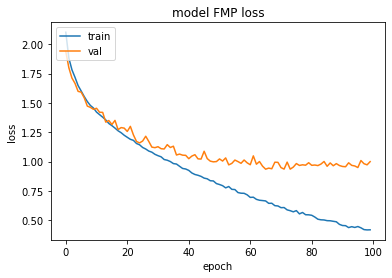

In [9]:
plt.plot(model_FMP_hist.history['loss'])
plt.plot(model_FMP_hist.history['val_loss'])
plt.title('model FMP loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

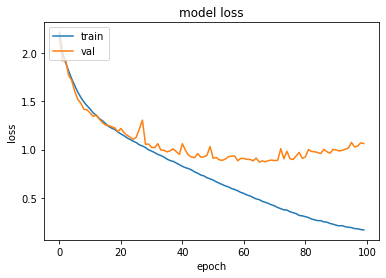

In [10]:
plt.plot(model_hist.history['loss'])
plt.plot(model_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

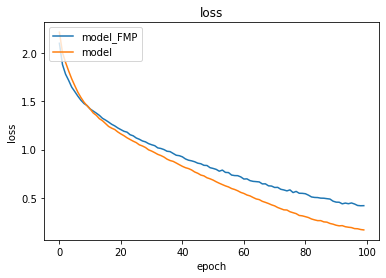

In [11]:
plt.plot(model_FMP_hist.history['loss'])
plt.plot(model_hist.history['loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['model_FMP', 'model'], loc='upper left')
plt.show()

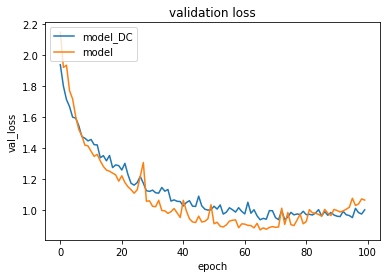

In [12]:
plt.plot(model_FMP_hist.history['val_loss'])
plt.plot(model_hist.history['val_loss'])
plt.title('validation loss')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['model_DC', 'model'], loc='upper left')
plt.show()

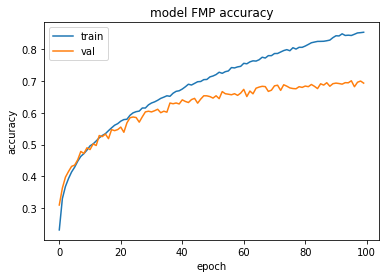

In [13]:
plt.plot(model_FMP_hist.history['accuracy'])
plt.plot(model_FMP_hist.history['val_accuracy'])
plt.title('model FMP accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

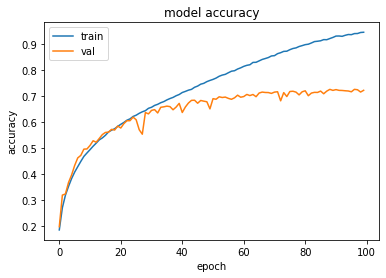

In [14]:
plt.plot(model_hist.history['accuracy'])
plt.plot(model_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

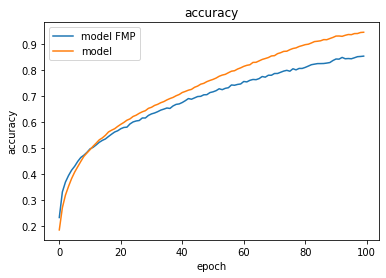

In [15]:
plt.plot(model_FMP_hist.history['accuracy'])
plt.plot(model_hist.history['accuracy'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['model FMP', 'model'], loc='upper left')
plt.show()

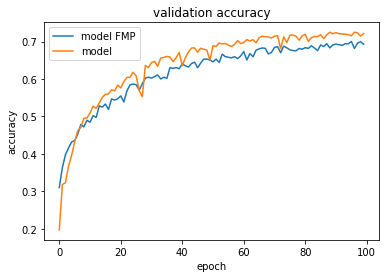

In [16]:
plt.plot(model_FMP_hist.history['val_accuracy'])
plt.plot(model_hist.history['val_accuracy'])
plt.title('validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['model FMP', 'model'], loc='upper left')
plt.show()

In [17]:
accuracy = tf.keras.metrics.Accuracy()
print('testing accuracy, model {:.4f}, model FMP {:.4f}'.format(accuracy(tf.argmax(model.predict(test_images), axis = 1), test_labels), accuracy(tf.argmax(model_FMP.predict(test_images), axis = 1), test_labels)))

testing accuracy, model 0.7184, model FMP 0.7026
